# DSA5206 Project Part 2: Analysis and Prediction of Air Quality Index (AQI) Using Time-Series Modeling and Dimensionality Reduction

## 1. Read and split dataset

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("data_date.csv")
df.head()

,Date,Country,Status,AQI Value
0,2022-07-21,Albania,Good,14
1,2022-07-21,Algeria,Moderate,65
2,2022-07-21,Andorra,Moderate,55
3,2022-07-21,Angola,Unhealthy for Sensitive Groups,113
4,2022-07-21,Argentina,Moderate,63


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
print("Date range:", df['Date'].min(), "to", df['Date'].max())

Date range: 2022-07-21 00:00:00 to 2025-05-29 00:00:00


### train-test splitting by time and country

In [8]:
train = df.groupby('Country').apply(lambda x: x[x['Date'] < x['Date'].quantile(0.8)]).reset_index(drop=True)
test = df.groupby('Country').apply(lambda x: x[x['Date'] >= x['Date'].quantile(0.8)]).reset_index(drop=True)
print(f"Train size: {len(train)} ({len(train)/len(df):.1%})")
print(f"Test size: {len(test)} ({len(test)/len(df):.1%})")

Train size: 15434 (79.5%)
Test size: 3975 (20.5%)


### check if there is data leakage (using India as an example)

In [12]:
india_train = train[train['Country'] == 'India']
india_test = test[test['Country'] == 'India']

print("India Train Date Range:", india_train['Date'].min(), "to", india_train['Date'].max())
print("India Test Date Range:", india_test['Date'].min(), "to", india_test['Date'].max())

India Train Date Range: 2022-07-21 00:00:00 to 2024-10-31 00:00:00
India Test Date Range: 2024-11-07 00:00:00 to 2025-05-29 00:00:00


## 2. EDA

### 2.1 Basic overview

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Basic stats
print("=== Basic Statistics ===")
print(train.describe())

# 2. Missing values
print("\n=== Missing Values ===")
print(train.isnull().sum())

# 3. Unique countries and date range
print("\n=== Unique Countries ===")
print(train['Country'].nunique())
print("\n=== Date Range ===")
print("Start:", train['Date'].min(), "| End:", train['Date'].max())

=== Basic Statistics ===
          AQI Value
count  15434.000000
mean      61.823247
std       48.489280
min        1.000000
25%       29.000000
50%       52.000000
75%       81.000000
max      963.000000

=== Missing Values ===
Date         0
Country      0
Status       0
AQI Value    0
dtype: int64

=== Unique Countries ===
142

=== Date Range ===
Start: 2022-07-21 00:00:00 | End: 2025-01-16 00:00:00


### 2.2 Temporal trends (AQI over time)

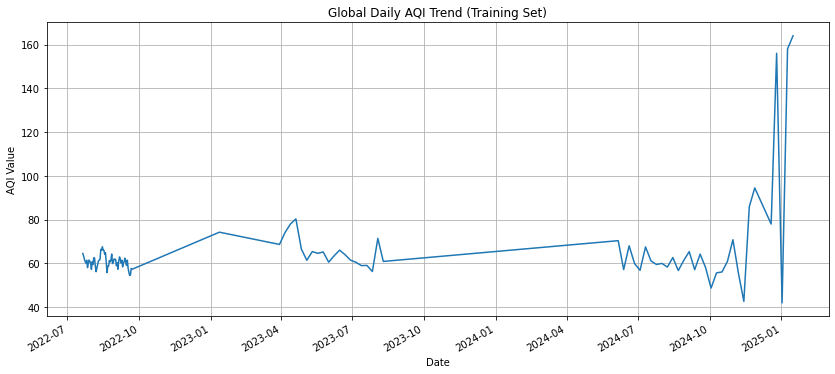

In [15]:
# Global AQI trend (daily mean)
plt.figure(figsize=(14, 6))
train.groupby('Date')['AQI Value'].mean().plot(title='Global Daily AQI Trend (Training Set)')
plt.xlabel('Date')
plt.ylabel('AQI Value')
plt.grid()
plt.show()


In [18]:
# Top 5 countries with highest average AQI
top_countries = train.groupby('Country')['AQI Value'].mean().nlargest(5).index
print(top_countries)

Index(['India', 'Qatar', 'China', 'Iraq', 'Iran'], dtype='object', name='Country')


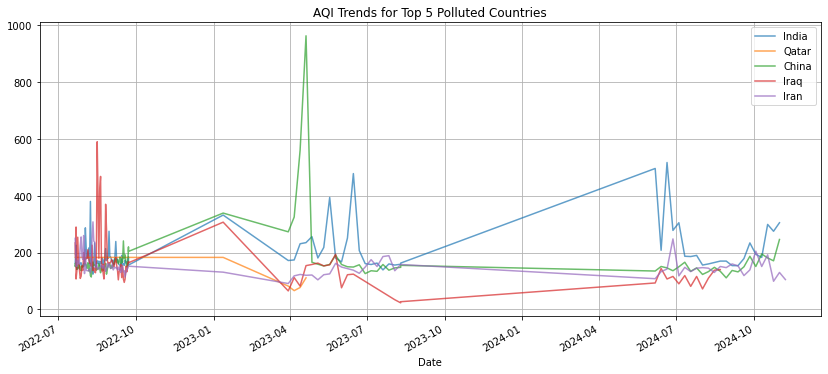

In [19]:
# Plot AQI trends for top countries
plt.figure(figsize=(14, 6))
for country in top_countries:
    country_data = train[train['Country'] == country].set_index('Date')
    country_data['AQI Value'].plot(label=country, alpha=0.7)
plt.title('AQI Trends for Top 5 Polluted Countries')
plt.legend()
plt.grid()
plt.show()

### 2.3 Seasonality and decomposition

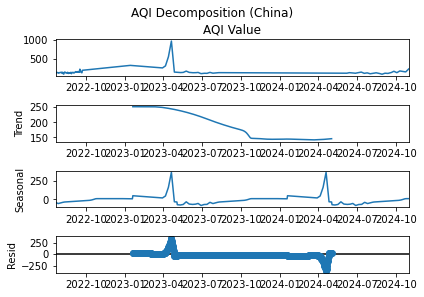

In [23]:
# use China as an example
country = 'China'  
country_data = train[train['Country'] == country].copy()

# Handle duplicates and set frequency
country_data = country_data.groupby('Date')['AQI Value'].mean().reset_index()  # Ensure unique dates
country_data = country_data.set_index('Date').asfreq('D')

# Interpolate small gaps
country_data['AQI Value'] = country_data['AQI Value'].interpolate()

# Decompose (use period=365 for yearly seasonality)
try:
    decomposition = seasonal_decompose(country_data['AQI Value'], period=365, model='additive')
    decomposition.plot()
    plt.suptitle(f'AQI Decomposition ({country})', y=1.02)
    plt.show()
except ValueError as e:
    print(f"Error: {e}. Check if period <= len(data) or adjust frequency.")

Decreasing overall trend, with yearly seasonality (higher AQI around May every year).

### 2.4 Distribution and outliers

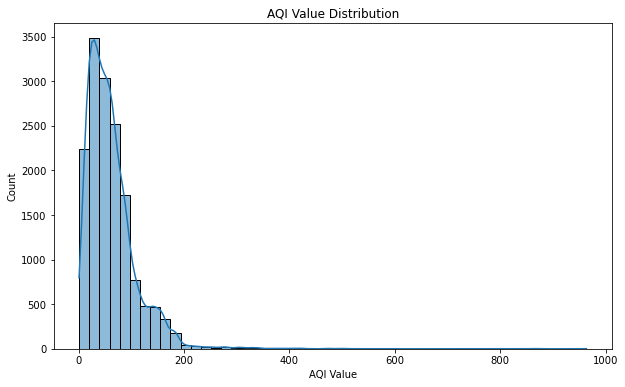

In [24]:
# Distribution of AQI values
plt.figure(figsize=(10, 6))
sns.histplot(train['AQI Value'], bins=50, kde=True)
plt.title('AQI Value Distribution')
plt.show()

Mostly below 200 (status = 'Moderate'), very clear skewness, so we need to perform log transformation. 

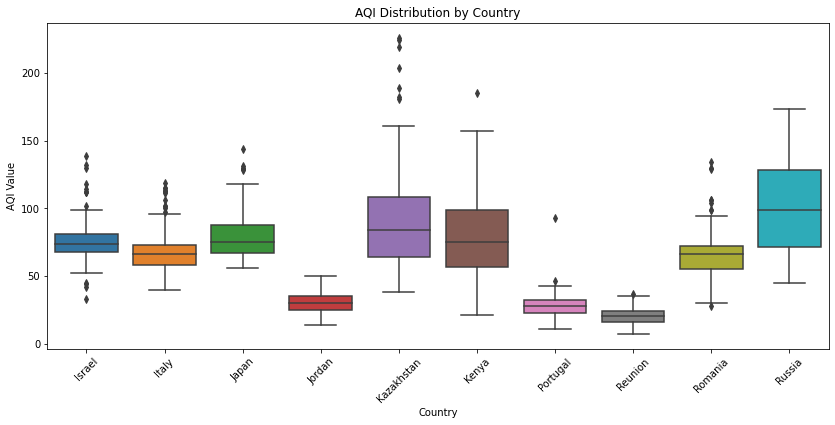

In [26]:
# Boxplot by country (top 10 countries)
plt.figure(figsize=(14, 6))
top_10 = train['Country'].value_counts().head(10).index
sns.boxplot(data=train[train['Country'].isin(top_10)], x='Country', y='AQI Value')
plt.xticks(rotation=45)
plt.title('AQI Distribution by Country')
plt.show()

### 2.5 Correlation with time

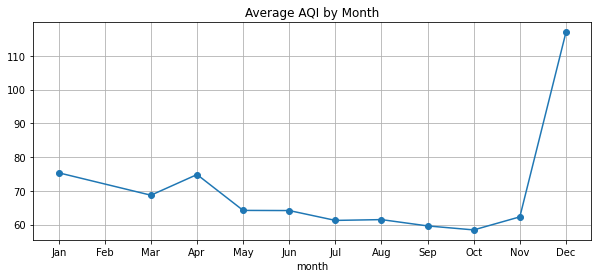

In [29]:
# Extract time features
train['year'] = train['Date'].dt.year
train['month'] = train['Date'].dt.month
train['day_of_week'] = train['Date'].dt.dayofweek  # Monday=0, Sunday=6

# Monthly AQI trends (global)
plt.figure(figsize=(10, 4))
train.groupby('month')['AQI Value'].mean().plot(marker='o')
plt.title('Average AQI by Month')
plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid()
plt.show()

Overall AQI is significantly higher in Dec than in other months. It generally shows a decreasing trend from Jan to Nov. 

### 2.6 Spatial patterns (country level)

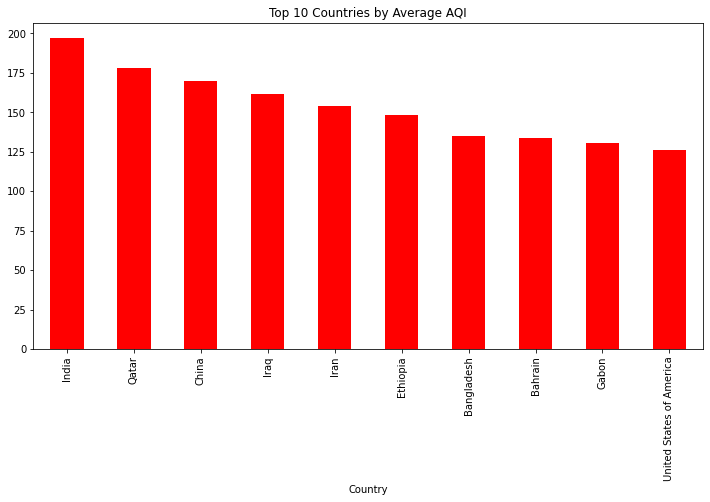

In [36]:
# Top/bottom 10 countries by mean AQI
mean_aqi = train.groupby('Country')['AQI Value'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
mean_aqi.head(10).plot(kind='bar', color='red', title='Top 10 Countries by Average AQI')
plt.show()

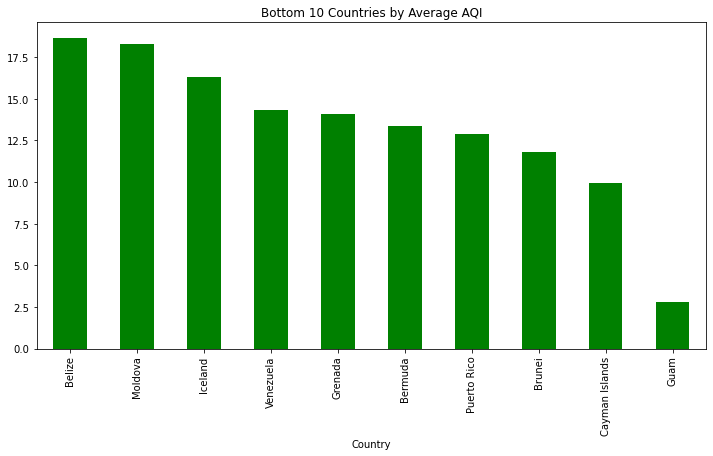

In [35]:
plt.figure(figsize=(12, 6))
mean_aqi.tail(10).plot(kind='bar', color='green', title='Bottom 10 Countries by Average AQI')
plt.show()

### 2.7 Stationarity (ADF test), autocorrelation

In [39]:
from statsmodels.tsa.stattools import adfuller

# use China as an example
country_data = train[train['Country'] == 'China'].set_index('Date')

result = adfuller(country_data['AQI Value'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")  # p < 0.05 implies stationarity

ADF Statistic: -6.149568442578658
p-value: 7.620171381435837e-08


This shows that data for China is stationary. This means that no differencing is needed -> I can set d=0 in ARIMA/SARIMA models.

/Users/leslie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


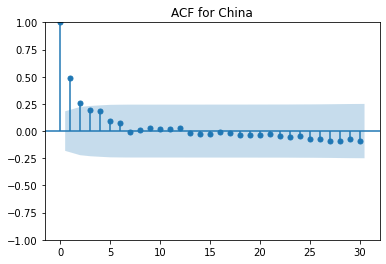

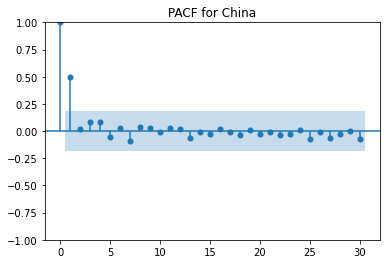

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF/PACF for China
plot_acf(country_data['AQI Value'], lags=30, title='ACF for China')
plot_pacf(country_data['AQI Value'], lags=30, title='PACF for China')
plt.show()

Model Selection:
1. ACF cuts off at lag 2 → Try MA(2) (q=2).

2. PACF cuts off at lag 1 → Try AR(1) (p=1).

Hence, a guess for the model is ARIMA(1,0,2).



/Users/leslie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/leslie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/leslie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              AQI Value   No. Observations:                  116
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -668.788
Date:                Sat, 07 Jun 2025   AIC                           1347.576
Time:                        15:10:05   BIC                           1361.343
Sample:                             0   HQIC                          1353.165
                                - 116                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        169.5734     49.210      3.446      0.001      73.124     266.023
ar.L1          0.7313      0.353      2.074      0.038       0.040       1.422
ma.L1         -0.2557      0.412     -0.620      0.5

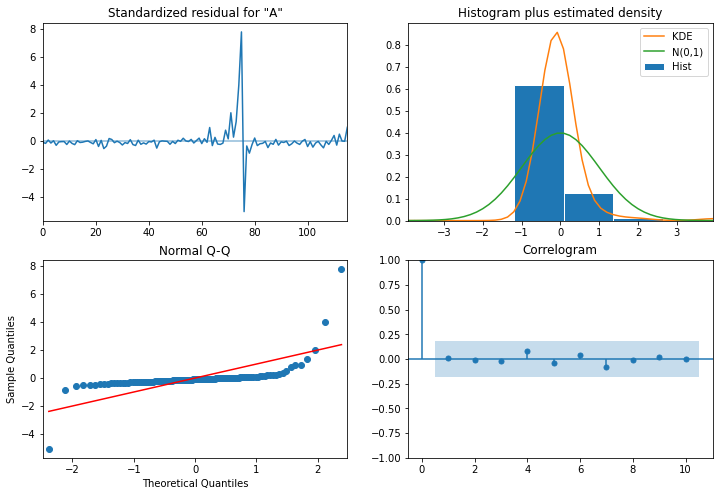

In [44]:
from statsmodels.tsa.arima.model import ARIMA

country_data_arima = train[train['Country'] == 'China'][['Date', 'AQI Value']].copy()
country_data_arima = country_data_arima.set_index('Date')['AQI Value'].dropna()

model = ARIMA(country_data_arima, order=(1, 0, 2)) 
arima_results = model.fit()

print(arima_results.summary())

# Plot diagnostics
arima_results.plot_diagnostics(figsize=(12, 8))
plt.show()


The result shows that there is probably an overfit in MA term, as the p-values are insignificant. There is also heteroskedasticity. Next, try AR(1) model with log data. 

/Users/leslie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


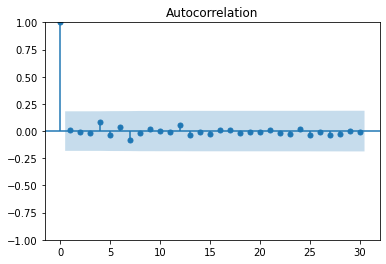

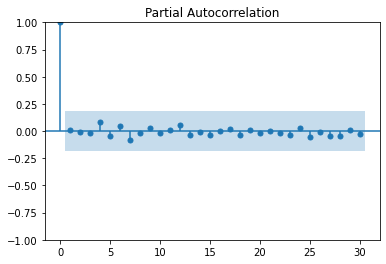

In [45]:
# Check residuals
residuals = arima_results.resid
plot_acf(residuals, lags=30)
plot_pacf(residuals, lags=30)
plt.show()

residual tests passed. 

/Users/leslie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/leslie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/leslie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              AQI Value   No. Observations:                  116
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  19.660
Date:                Sat, 07 Jun 2025   AIC                            -33.321
Time:                        15:21:24   BIC                            -25.060
Sample:                             0   HQIC                           -29.967
                                - 116                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0862      0.087     58.686      0.000       4.916       5.256
ar.L1          0.6408      0.029     22.333      0.000       0.585       0.697
sigma2         0.0415      0.002     18.538      0.0

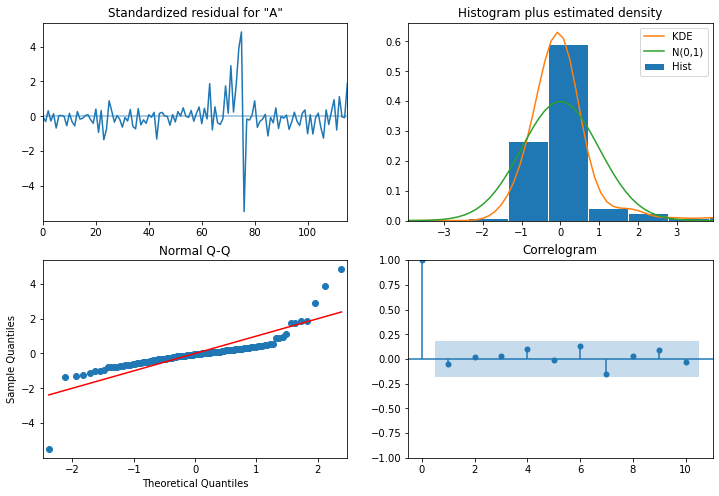

In [48]:
# try AR(1) with log data
country_data_log = np.log(country_data_arima)
model_log = ARIMA(country_data_log, order=(1, 0, 0))
results_log = model_log.fit()

# Check diagnostics
print(results_log.summary())
results_log.plot_diagnostics(figsize=(12, 8))
plt.show()

We can see large improvements after taking log of the data and applying AR(1). This means that MA model is probably overfitting. 

## 3. Data preprocessing based on training insights

In [51]:
# Most AQI values are < 200 -> Apply a log transform to reduce right skewness
train['AQI_log'] = np.log1p(train['AQI Value'])  
test['AQI_log'] = np.log1p(test['AQI Value'])   

In [52]:
# Country encoding: use Target Encoding (mean AQI per country) instead of one-hot encoding to avoid high dimensionality.
country_means = train.groupby('Country')['AQI_log'].mean().to_dict()
train['Country_encoded'] = train['Country'].map(country_means)
test['Country_encoded'] = test['Country'].map(country_means)  # Use train's means

In [53]:
# Status encoding: convert Status to ordinal values based on severity
status_order = {'Good': 0, 'Moderate': 1, 'Unhealthy for Sensitive Groups': 2, 'Unhealthy': 3, 'Very Unhealthy': 4, 'Hazardous': 5}  
train['Status_encoded'] = train['Status'].map(status_order)
test['Status_encoded'] = test['Status'].map(status_order)

In [54]:
# Extract time features for test as we already done for train
test['year'] = test['Date'].dt.year
test['month'] = test['Date'].dt.month
test['day_of_week'] = test['Date'].dt.dayofweek  # Monday=0, Sunday=6

In [ ]:
# Normalization
from sklearn.preprocessing import StandardScaler

numeric_cols = ['AQI_log', 'Country_encoded', 'month', 'year', 'day_of_week']
scaler = StandardScaler().fit(train[numeric_cols])
train[numeric_cols] = scaler.transform(train[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])  # Use train's scaler

In [56]:
train.head()

,Date,Country,Status,AQI Value,year,month,day_of_week,AQI_log,Country_encoded,Status_encoded
0,2022-07-21,Albania,Good,14,-0.683012,-0.39301,0.000333,-1.457018,-1.148001,0
1,2022-07-21,Albania,Good,17,-0.683012,-0.39301,0.000333,-1.227968,-1.148001,0
2,2022-07-22,Albania,Good,15,-0.683012,-0.39301,0.643246,-1.375938,-1.148001,0
3,2022-07-22,Albania,Good,15,-0.683012,-0.39301,0.643246,-1.375938,-1.148001,0
4,2022-07-22,Albania,Good,20,-0.683012,-0.39301,0.643246,-1.034310,-1.148001,0


In [57]:
train.tail()

,Date,Country,Status,AQI Value,year,month,day_of_week,AQI_log,Country_encoded,Status_encoded
15429,2023-06-08,Zambia,Moderate,58,0.616015,-1.05928,0.000333,0.263459,1.194897,1
15430,2023-06-15,Zambia,Unhealthy,167,0.616015,-1.05928,0.000333,1.578077,1.194897,3
15431,2023-06-22,Zambia,Moderate,83,0.616015,-1.05928,0.000333,0.707281,1.194897,1
15432,2023-06-29,Zambia,Moderate,77,0.616015,-1.05928,0.000333,0.614180,1.194897,1
15433,2023-07-06,Zambia,Moderate,70,0.616015,-0.39301,0.000333,0.496052,1.194897,1


In [62]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

## 4. Method 1: dimensionality reduction

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
train.head()

,Date,Country,Status,AQI Value,year,month,day_of_week,AQI_log,Country_encoded,Status_encoded
0,2022-07-21,Albania,Good,14,-0.683012,-0.39301,0.000333,-1.457018,-1.148001,0
1,2022-07-21,Albania,Good,17,-0.683012,-0.39301,0.000333,-1.227968,-1.148001,0
2,2022-07-22,Albania,Good,15,-0.683012,-0.39301,0.643246,-1.375938,-1.148001,0
3,2022-07-22,Albania,Good,15,-0.683012,-0.39301,0.643246,-1.375938,-1.148001,0
4,2022-07-22,Albania,Good,20,-0.683012,-0.39301,0.643246,-1.034310,-1.148001,0


In [ ]:
from sklearn.decomposition import PCA

# Select normalized features (exclude raw AQI, Date, and categorical columns)
features = train[['AQI_log', 'Country_encoded', 'month', 'year', 'day_of_week']]

# Add temporal aggregates (e.g., mean AQI per month per country) -> capture seasonal trends in the clustering.
train['country_month'] = train['Country'] + '_' + train['month'].astype(str)
monthly_means = train.groupby('country_month')['AQI_log'].mean().to_dict()
train['monthly_mean'] = train['country_month'].map(monthly_means)
features['monthly_mean'] = train['monthly_mean']

<ipython-input-7-75272c39a746>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['monthly_mean'] = train['monthly_mean']


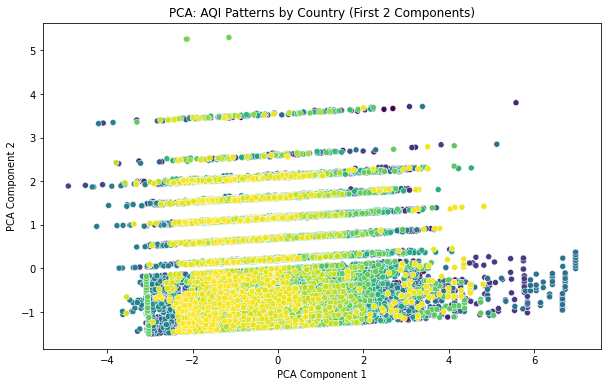

In [8]:
# Fit PCA on training data
pca = PCA(n_components=2)  # Reduce to 2D for visualization
pca_results = pca.fit_transform(features)

# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_results[:, 0], y=pca_results[:, 1], hue=train['Country'], palette='viridis', legend=False)
plt.title('PCA: AQI Patterns by Country (First 2 Components)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [9]:
# Check explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.44399029 0.2131338 ]


We can observe that there are horizontal lines in the graph. PCA components are linear combinations of features, so horizontal lines indicate that PC1 (x-axis) captures most of the variance, which is consistent with the explained variance ratio of 0.44 for PC1 vs. 0.21 for PC2. Points clustered near the x-axis suggest PC2 (y-axis) contributes little to separating countries.

Secondly, same-color clusters imply countries with similar AQI trends are grouped, but the mixing indicates PCA struggles to disentangle non-linear relationships. Colors are mixed and not varying monotonically with the variables, which means variables are not expanding with same information. Hence PCA does not perform very well on the dataset. Next, we can try kernel PCA.


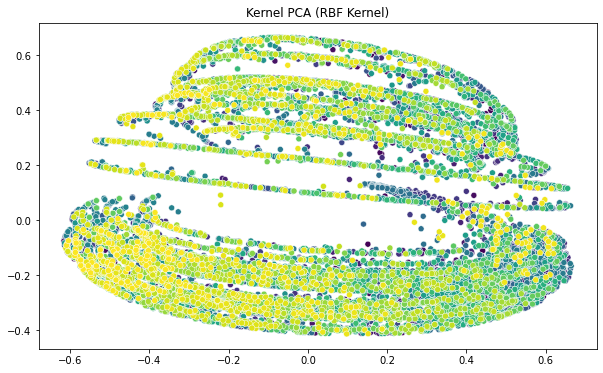

In [16]:
# try kernel PCA
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.1, random_state=42)
kpca_results = kpca.fit_transform(features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=kpca_results[:, 0], y=kpca_results[:, 1], hue=train['Country'], palette='viridis', legend=False)
plt.title('Kernel PCA (RBF Kernel)')
plt.show()

Again, the result is not very good as colors are mixed. However, the "roll" shape indicates that Kernel PCA (with RBF kernel) successfully unfolded non-linear relationships into a higher-dimensional space. Hence, the data seems to have global non-linear structure. Next, test local neighbourhoods with local linear embedding.

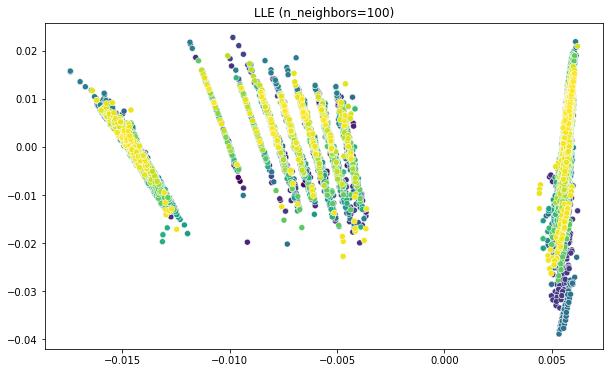

In [27]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=100, random_state=42)
lle_results = lle.fit_transform(features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=lle_results[:, 0], y=lle_results[:, 1], hue=train['Country'], palette='viridis', legend=False)
plt.title(f'LLE (n_neighbors=100)')
plt.show()

We can observe vertical streaks, which suggest that LLE preserved local neighborhoods but struggled to align them globally. The clusters may represent a group of countries with distinct AQI dynamics (e.g., extreme seasonality or outliers). The data has local manifold structure (e.g., subgroups of countries with similar monthly patterns).

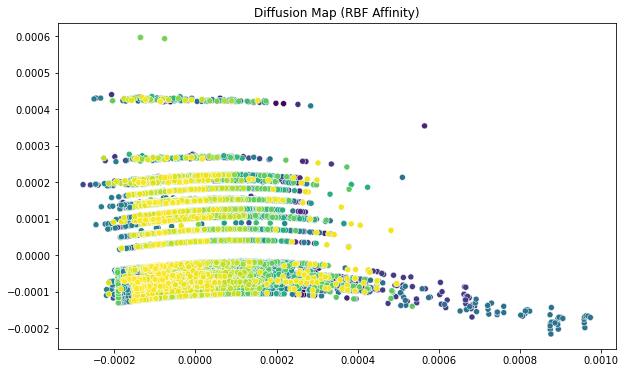

In [30]:
from sklearn.manifold import SpectralEmbedding  # Approximation of diffusion maps

diffusion = SpectralEmbedding(n_components=2, affinity='rbf', gamma=0.1, random_state=42)
diffusion_results = diffusion.fit_transform(features)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=diffusion_results[:, 0], y=diffusion_results[:, 1], hue=train['Country'], palette='viridis', legend=False)
plt.title('Diffusion Map (RBF Affinity)')
plt.show()

Similar to PCA, the horizontal lines suggest that the first diffusion component (x-axis) captures the dominant global trend (e.g., overall pollution levels). The small cluster near the x-axis indicates a distinct subgroup of countries that behave differently from the main trend (e.g., extreme outliers or unique seasonal patterns). From the graphs, we can see that the data points are roughly clustered into 3 groups. 

/Users/leslie/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0 size: 4680
Cluster 1 size: 3306
Cluster 2 size: 7448


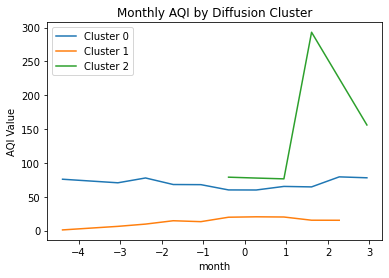

In [ ]:
from sklearn.cluster import KMeans

# Cluster diffusion coordinates
kmeans = KMeans(n_clusters=3).fit(diffusion_results)
train['cluster'] = kmeans.labels_

# Compare cluster trends
for cluster_id in range(3):
    cluster_data = train[train['cluster'] == cluster_id]
    print(f"Cluster {cluster_id} size:", len(cluster_data))
    sns.lineplot(data=cluster_data, x='month', y='AQI Value', ci=None, label=f'Cluster {cluster_id}')
plt.title('Monthly AQI by Diffusion Cluster')
plt.show()

Cluster 1 (Flat, AQI 0-25): Likely clean countries with stable, low pollution.

Cluster 0 (Flat, AQI ~75): Moderate-pollution countries with minor fluctuations (e.g., rural regions with seasonal agriculture).

Cluster 2 (High variability, AQI >75): High-pollution countries with volatile trends (e.g., industrial nations or cities with traffic peaks).

We can take this into consideration and perform a hybrid-modeling approach in the next step, i.e., Combine cluster-specific models with dimensionality-reduced features for robustness. Hence, we can build cluster-specific ARIMA models for prediciton. 

However, as we want to use the dimensionality reduction in the next prediction model, we need the `transform` method from sklearn. As neither LLE nor Spectral Embedding package provides this method, we roll back to PCA and kernel PCA. After testing with KMeans, PCA gives a more similar clustering result as diffusion map as compared to kernel PCA, with 3 distinct clusters, as shown below. This is also a reflection of the above analysis graphs, where PCA shows clearer clustering than kernel PCA. Hence, we will use PCA to continue building the hybrid model. 

/Users/leslie/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0 size: 3643
Cluster 1 size: 4988
Cluster 2 size: 6803


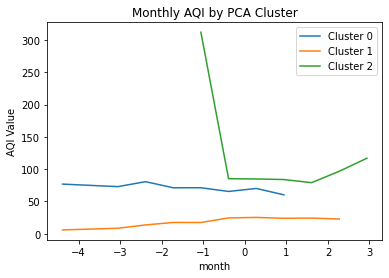

In [90]:
from sklearn.cluster import KMeans

# Cluster diffusion coordinates
kmeans = KMeans(n_clusters=3).fit(pca_results)
train['cluster'] = kmeans.labels_

# Compare cluster trends
for cluster_id in range(3):
    cluster_data = train[train['cluster'] == cluster_id]
    print(f"Cluster {cluster_id} size:", len(cluster_data))
    sns.lineplot(data=cluster_data, x='month', y='AQI Value', ci=None, label=f'Cluster {cluster_id}')
plt.title('Monthly AQI by PCA Cluster')
plt.show()

## 5. Method 2: prediction

The full pipeline: 1. Dimensionality Reduction -> 2. K-means Clustering -> 3. Cluster-Specific auto_arima 
-> 4. KNN Cluster Assignment -> 5. XGBoost Hybrid -> 6. Evaluation

In [108]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

train['pca_x'] = pca_results[:, 0]
train['pca_y'] = pca_results[:, 1]
train['AQI_log_raw'] = np.log1p(train['AQI Value'])  
test['AQI_log_raw'] = np.log1p(test['AQI Value'])  

In [ ]:
cluster_models = {}
for cluster_id in [0, 1, 2]:
    cluster_data = train[train['cluster'] == cluster_id].set_index('Date')['AQI_log_raw']
    
    # Auto-tune ARIMA (seasonal=False for simplicity)
    model = auto_arima(
        cluster_data,
        seasonal=False,  
        stepwise=True,
        suppress_warnings=True,
        trace=True  # Print tuning logs
    )
    print(f"Cluster {cluster_id} Best ARIMA Order:", model.order)
    cluster_models[cluster_id] = model

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3845.279, Time=1.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=20695.453, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=16326.299, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3844.133, Time=0.27 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=13437.388, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3878.650, Time=0.17 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3846.167, Time=0.35 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=11484.941, Time=0.55 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3845.550, Time=0.29 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3844.187, Time=0.64 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3734.031, Time=1.40 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4621.014, Time=0.50 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3745.165, Time=1.08 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept 

Cluster 0 Best ARIMA Order: (5, 0, 3)

Cluster 1 Best ARIMA Order: (2, 1, 1)

Cluster 2 Best ARIMA Order: (4, 0, 2)

In [110]:
# Create 'country_month' key for TEST set (same format as train)
test['country_month'] = test['Country'] + '_' + test['month'].astype(str)

# Assign monthly means from TRAIN set
test['monthly_mean'] = test['country_month'].map(monthly_means)

# Handle missing country-month pairs (unseen in training)
test['monthly_mean'] = test['monthly_mean'].fillna(train['AQI_log'].mean()) 


In [111]:
test_features = test[['AQI_log', 'Country_encoded', 'month', 'year', 'day_of_week', 'monthly_mean']]
test_pca = pca.transform(test_features)
test['pca_x'] = test_pca[:, 0]
test['pca_y'] = test_pca[:, 1]

# Fit KNN on PCA coordinates
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train[['pca_x', 'pca_y']], train['cluster'])

# Predict clusters for test set
test['cluster'] = knn.predict(test[['pca_x', 'pca_y']])

In [112]:
train['ARIMA_pred'] = np.nan
arima_preds = train['ARIMA_pred'].values  

for cluster_id in [0, 1, 2]:
    cluster_mask = train['cluster'] == cluster_id
    if cluster_mask.any():
        arima_preds[cluster_mask] = cluster_models[cluster_id].predict_in_sample()

train['ARIMA_pred'] = arima_preds 

In [113]:
for cluster_id in [0, 1, 2]:
    cluster_mask = test['cluster'] == cluster_id
    if cluster_mask.any():
        n_periods = int(cluster_mask.sum())
        
        model = cluster_models[cluster_id]
        
        forecasts = model.predict(
            n_periods=n_periods,
            return_conf_int=False
        )

        test.loc[cluster_mask, 'ARIMA_pred'] = forecasts.values

/Users/leslie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/leslie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/leslie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [114]:
# Prepare features: ARIMA forecasts + PCA coords + temporal vars
features = ['ARIMA_pred', 'pca_x', 'pca_y', 'month', 'year', 'cluster', 'Country_encoded', 'day_of_week']
X_train = train[features]
y_train = train['AQI_log_raw']
X_test = test[features]


In [115]:
# Check for NaNs in training features
print("NaNs in training features:")
print(X_train.isna().sum())

# Check for NaNs in test features
print("\nNaNs in test features:")
print(X_test.isna().sum())

NaNs in training features:
ARIMA_pred         0
pca_x              0
pca_y              0
month              0
year               0
cluster            0
Country_encoded    0
day_of_week        0
dtype: int64

NaNs in test features:
ARIMA_pred         0
pca_x              0
pca_y              0
month              0
year               0
cluster            0
Country_encoded    0
day_of_week        0
dtype: int64


In [116]:
# Train XGBoost
xgb = GradientBoostingRegressor(random_state=42)
xgb.fit(X_train, y_train)

# Final predictions (revert log transform)
test['AQI_pred'] = np.exp(xgb.predict(X_test))

## 6. Evaluation

In [117]:
# Cluster-specific RMSE
for cluster_id in [0, 1, 2]:
    cluster_test = test[test['cluster'] == cluster_id]
    if not cluster_test.empty:
        rmse = np.sqrt(mean_squared_error(
            cluster_test['AQI Value'],  # True values (original scale)
            cluster_test['AQI_pred'])
        )
        print(f"Cluster {cluster_id} RMSE:", rmse)

# Global RMSE
global_rmse = np.sqrt(mean_squared_error(
    test['AQI Value'],
    test['AQI_pred'])
)
print("Global RMSE:", global_rmse)

Cluster 0 RMSE: 28.3808608678309
Cluster 1 RMSE: 10.43327448508475
Cluster 2 RMSE: 46.42528133190264
Global RMSE: 31.555777807846304


Key Insights

1. Cluster 1 is the Best-Performing Group: With an RMSE of 10.4, this cluster's AQI patterns are being modeled nearly perfectly, considering the width of the bin of the status (50 for status code 0 and 1, and 100 for the rest). This is a reflection of the more stable AQI trends shown in the PCA cluster graph. It also means that cluster 1 better aligns with ARIMA assumptions (stationarity, etc.)

2. cluster 2 has the highest error: The 46.43 RMSE is significantly higher than others. This means that the model struggles most with this cluster's patterns.

3. Global RMSE (31.56) is Dominated by Cluster 2: The global error is pulled up by Cluster 2's poor performance. The future work can be improving cluster 2 through different ARIMA orders, validating time series patterns, etc., which can disproportionally improve the overall performance. Moreover, we assumed no seasonality in building ARIMA model, which can be tested and added in the future. 

In [ ]:
# Define AQI bins and corresponding status codes
aqi_bins = [0, 50, 100, 200, 300, 400, 500]
status_codes = [0, 1, 2, 3, 4, 5] 

# Convert predicted AQI to status
test['Predicted_Status'] = pd.cut(
    test['AQI_pred'],
    bins=aqi_bins,
    labels=status_codes,
    right=False
).astype(int)

In [119]:
from sklearn.metrics import classification_report, confusion_matrix

status_order = {'Good': 0, 'Moderate': 1, 'Unhealthy for Sensitive Groups': 2, 'Unhealthy': 3, 'Very Unhealthy': 4, 'Hazardous': 5}  

y_true = test['Status_encoded']
y_pred = test['Predicted_Status']

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=status_order.keys()))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Classification Report:
                                precision    recall  f1-score   support

                          Good       0.95      0.84      0.89      1714
                      Moderate       0.62      0.86      0.72      1361
Unhealthy for Sensitive Groups       0.42      0.36      0.38       583
                     Unhealthy       0.42      0.09      0.15       235
                Very Unhealthy       0.29      0.03      0.06        58
                     Hazardous       0.00      0.00      0.00        24

                      accuracy                           0.72      3975
                     macro avg       0.45      0.36      0.37      3975
                  weighted avg       0.71      0.72      0.70      3975


Confusion Matrix:
[[1444  268    2    0    0    0]
 [  80 1174  107    0    0    0]
 [   4  368  208    3    0    0]
 [   0   77  136   22    0    0]
 [   0    1   35   20    2    0]
 [   0    1   11    7    5    0]]


/Users/leslie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leslie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leslie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Key insights:

**Classification report**
- Precision is the % of correct predictions for a class out of all predictions for that class.  
  - The Status getting the highest precision is "Good" (0.95), for which 95% of instances predicted as "Good" were correct. On the other hand, low precision (e.g., 0.00 for "Hazardous") means many false positives.  

- Recall (Sensitivity) is the % of actual class instances correctly predicted.  
  - The Status getting the highest recall is "Moderate" (0.86), for which 86% of actual "Moderate" instances were correctly identified, while the lowest recall is 0.03 for "Very Unhealthy", which means most instances were missed.  

- F1-score is the harmonic mean of precision and recall (balances both).  
  - High F1 (e.g., 0.89 for "Good") indicates strong performance.  while near-zero F1 (e.g., 0.00 for "Hazardous") suggests failure to predict the class.  

- Overall % of correct predictions is shown by accuracy of 72%. However, there is poor performance on minority classes, indicated by the low 0.37 F1 from macro avg. Once looking at the weighted avg, the F1 improves and become 0.70, because majority classes ("Good", "Moderate") perform well.  

**Confusion Matrix**
- Diagonal (Correct Predictions):  
  - "Good" (1444/1714 correct), "Moderate" (1174/1361 correct) dominate.  
  - Minority classes (e.g., "Hazardous": 0/24 correct) are misclassified entirely.  

- Off-Diagonal (Errors):  
  - "Unhealthy for Sensitive Groups" misclassified as "Moderate" (368): Largest error, likely due to class similarity or imbalance.  
  - "Moderate" misclassified as "Good" (268): Second-largest error.  
  - Minority classes (e.g., "Very Unhealthy", "Hazardous") are often predicted as "Moderate" or "Unhealthy for Sensitive Groups".  

**Overall discussion**

1. Class Imbalance Issues:  
   - Model performs well on majority classes ("Good", "Moderate") but fails on rare classes ("Hazardous", "Very Unhealthy").  This can be reduced by resampling (oversampling minority classes), class weights, or anomaly detection for rare cases.  

2. Misclassification Patterns:  
   - Errors often flow toward "Moderate" or "Unhealthy for Sensitive Groups".  This might be due to overlapping features and insufficient examples for rare classes.  

In [120]:
for cluster_id in [0, 1, 2]:
    cluster_mask = test['cluster'] == cluster_id
    if cluster_mask.any():
        print(f"\nCluster {cluster_id} Status Prediction:")
        y_true_cluster = test.loc[cluster_mask, 'Status_encoded']
        y_pred_cluster = test.loc[cluster_mask, 'Predicted_Status']
        print(classification_report(y_true_cluster, y_pred_cluster))


Cluster 0 Status Prediction:
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      1137
           1       0.63      0.84      0.72       941
           2       0.44      0.46      0.45       401
           3       0.42      0.14      0.21       162
           4       0.29      0.05      0.08        41
           5       0.00      0.00      0.00        14

    accuracy                           0.70      2696
   macro avg       0.45      0.38      0.39      2696
weighted avg       0.71      0.70      0.69      2696


Cluster 1 Status Prediction:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       455
           1       0.50      0.79      0.61        19

    accuracy                           0.96       474
   macro avg       0.75      0.88      0.80       474
weighted avg       0.97      0.96      0.96       474


Cluster 2 Status Prediction:
              precision    recall  f1-sc

/Users/leslie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leslie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leslie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leslie/op

Key insights: 

**Cluster 0 (Largest Cluster, ~2.7k Samples)**
- Similar to global report, with strong results for majority classes (`0: Good`, `1: Moderate`) but poor performance for minority classes (`4: Very Unhealthy`, `5: Hazardous`).  

**Cluster 1 (Smallest Cluster, ~500 Samples)**
- Exceptional for `Good` (Class 0: 0.99 precision, 0.97 recall) but poor for `Moderate` (Class 1: 0.50 precision, 0.79 recall).  This cluster likely represents a "clean" subset where "Good" status is easy to predict.  Moveover, "Moderate" is rare here (only 19 samples), and the model struggles (61% F1).  

**Cluster 2 (~800 Samples)**
- Worst overall (62% accuracy), with severe misclassification:  
  - `Moderate` (Class 1): High recall (0.92) but low precision (0.61) -> Many other classes are mislabeled as "Moderate".  
  - Minority classes (`3-5`) are entirely missed (0.00 F1).  
  - This is a reflection of the PCA cluster graph, which shows that this cluster may represent ambiguous or noisy data where features overlap across classes.  
